# A/B testing: Decisiones de negocio basadas en datos

## **Descripción del proyecto**
**Descripción de los datos**

1. Datos utilizados en la primera parte del proyecto
/datasets/hypotheses_us.csv 
* Hypotheses: breves descripciones de las hipótesis
*Reach: alcance del usuario, en una escala del uno a diez
*Impact: impacto en los usuarios, en una escala del uno al diez
*Confidence: confianza en la hipótesis, en una escala del uno al diez
*Effort: los recursos necesarios para probar una hipótesis, en una escala del uno al diez.
2. Datos utilizados en la segunda parte del proyecto:
/datasets/orders_us.csv 
* transactionId: identificador de pedido
* visitorId: identificador del usuario que realizó el pedido
*date: fecha del pedido
*revenue: ingresos del pedido
*group: el grupo del test A/B al que pertenece el usuario
3. Información extra: /datasets/visits_us.csv
* date: la fecha
*group: grupo del test A/B
*visits: el número de visitas en la fecha especificada para el grupo de test A/B especificado

## **Carga y Preprocesamiento de datos**

In [1]:
import pandas   as pd
import datetime as dt
import scipy.stats as stats
from scipy import stats as st
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

In [2]:
hypotheses = 'https://code.s3.yandex.net/datasets/hypotheses_us.csv'
hypotheses =  pd.read_csv(hypotheses, sep=';', nrows=500)
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_us.csv')
visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_us.csv')

### **Hipótesis**

In [3]:
hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
pd.set_option('max_colwidth', 450)
hypotheses.columns= hypotheses.columns.str.lower()
hypotheses

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


### **Órdenes**

In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [6]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [7]:
customer_exclude = orders.groupby('visitorId', as_index = False).agg({'group':'nunique'})
customer_exclude = list(customer_exclude.query('group == 2')['visitorId']) # En esta lista tenemos los visitorId que se encuentran en ambos grupos (A y B). Los vamos a excluir del estudio.

In [8]:
orders_filtred = orders.query('visitorId not in @customer_exclude')
orders_filtred # En esta tabla tenemos a los VisitorId que no participaron en ambos grupos al mismo tiempo, sólo los visitantes únicos.

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A


Después de filtrar las órdenes podemos ver que el número de filas se redujo de 1197 a 1016 filas, esto reprenta el 84% del dataframe original, removimos el 16% de los datos ya que eran usuarios repetidos en ambos grupos.

### **Visitas**

In [9]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [10]:
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [11]:
# Ahora vamos a remover de `visits` a los usuarios que están repetidos para ambos grupos a partir de la lista de los visitorId que son repetidos y vamos a excluir.
orders_temp = orders.query('visitorId in @customer_exclude').reset_index(drop = True)
orders_temp.loc[:,'corr'] = -1
orders_correcting_info = orders_temp.groupby(['date','group']).agg({'corr':'sum'}).fillna(0).reset_index(drop=False)
orders_correcting_info['corr'] = orders_correcting_info['corr'].astype(int)
visits_filtred = visits.merge(orders_correcting_info,
                              left_on=['date', 'group'],
                              right_on=['date', 'group'])
visits_filtred['visits'] = visits_filtred['visits'] + visits_filtred['corr'] 
visits_filtred = visits_filtred.drop('corr', axis=1)

In [12]:
visits_filtred.head()

,date,group,visits
0,2019-08-01,A,718
1,2019-08-02,A,618
2,2019-08-04,A,712
3,2019-08-05,A,753
4,2019-08-06,A,664


In [13]:
visits_filtred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 0 to 55
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    56 non-null     object
 1   group   56 non-null     object
 2   visits  56 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.8+ KB


Hasta ahora no hemos encontrado valores faltantes o duplicados en ninguno de los datasets, cambiamos únicamente por conveniencia el nombre de las columnas (pasamos todo a minúsculas) en el dataframe `hypotheses`. Quitamos los usuarios repetidos en ambos grupos apartir del visitorId para excluirlos de las órdenes y posteriormente de la tabla de las visitas de acuerdo con el grupo y la fecha en la que realizaron la visita. Podemos ver que la columna visits se reduce en 1 unidad y en algunos casos se elimina la fila completamente, esto da un dataframe resultante con el 90% de los datos originales.

## **Parte 1. Priorizar hipótesis**

Vamos a calcular primeramente los factores ICE y RICE. Estos nos van a ayudar a determinar las hipótesis a priorizar y veremos la diferencia en el rating entre ambas debido a que RICE toma en cuenta el alcance que tendrá con respecto de los usuarios o clientes y ICE es más general.

In [14]:
hypotheses['ICE'] = (hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']
hypotheses['RICE'] = (hypotheses['reach'] * hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']
hypotheses[['hypothesis', 'ICE', 'RICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE,RICE
8,Launch a promotion that gives users discounts on their birthdays,16.200000,16.2
0,Add two new channels for attracting traffic. This will bring 30% more users,13.333333,40.0
7,Add a subscription form to all the main pages. This will help you compile a mailing list,11.200000,112.0
6,Show banners with current offers and sales on the main page. This will boost conversion,8.000000,40.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,7.000000,56.0
1,Launch your own delivery service. This will shorten delivery time,2.000000,4.0
5,Add a customer review page. This will increase the number of orders,1.333333,4.0
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,1.125000,9.0
4,Change the background color on the main page. This will increase user engagement,1.000000,3.0


La priorización de las hipótesis de acuerdo con ICE/RICE cambió la posición de las hipótesis algunos lugares de la mayoría de ellas, la #4 quedó en la misma posiciones para ambos (último), lo cuál de entrada nos puede decir que cambiar el color de la página no es muy significativo; por otro lado el CTA y promociones de descuentos podrían ser las mejores ideas para aumentar los ingresos siendo las dos primeras que quedaron en primer lugar para ambos factores de priorización.

## **Parte 2. Análisis de test A/B**

In [15]:
orders_filtred['date'] = pd.to_datetime(orders_filtred['date'])

<ipython-input-15-1e8cabd8f244>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_filtred['date'] = pd.to_datetime(orders_filtred['date'])


In [16]:
visits_filtred['date'] = pd.to_datetime(visits_filtred['date'])

In [17]:
ordersByUsersA = orders_filtred[orders_filtred['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = orders_filtred[orders_filtred['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders'] 

In [18]:
#usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 4]['visitorId'], ordersByUsersB[ordersByUsersB['orders'] > 4]['visitorId']], axis = 0)
#usersWithExpensiveOrders = orders_filtred[orders_filtred['revenue'] > 20000]['visitorId']
#abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
#print(abnormalUsers.head(5))
#print(abnormalUsers.shape)

Ahora vamos a separar los datos acumulados, comenzando por calcular los datos acumulados de las órdenes y visitas diarias, y posteriormente lo separaremos por grupo A y B.

In [19]:
#  Matriz con valores únicos de parejas fecha-grupo con el método .drop_duplicates()
datesGroups = orders_filtred[['date','group']].drop_duplicates()
ordersAggregated = datesGroups.apply(lambda x: orders_filtred[np.logical_and(orders_filtred['date'] <= x['date'],
                                                                     orders_filtred['group'] == x['group'])].agg({'date' : 'max',
                                                                                                          'group' : 'max',
                                                                                                          'transactionId' : 'nunique',
                                                                                                          'visitorId' : 'nunique',
                                                                                                          'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) # Acumulados agregados sobre los pedidos 

visitorsAggregated = datesGroups.apply(lambda x: visits_filtred[np.logical_and(visits_filtred['date'] <= x['date'],
                                                                         visits_filtred['group'] == x['group'])].agg({'date' : 'max',
                                                                                                                'group' : 'max',
                                                                                                                'visits' : 'sum'}), axis=1).sort_values(by=['date','group']) # Acumulados agregados sobre los visitantes

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']) # Fusión de ambas tablas en una con los datos diarios acumulados de órdenes y visitas únicas por fecha y grupo
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visits']

In [20]:
cumulativeData.head()

,date,group,orders,buyers,revenue,visits
0,2019-08-01,A,23,19,2266.6,718
1,2019-08-01,B,17,17,967.2,709
2,2019-08-02,A,42,36,3734.9,1336
3,2019-08-02,A,42,36,3734.9,1336
4,2019-08-02,B,40,39,3535.3,1289


In [21]:
cumulativeData['date'].describe()

<ipython-input-21-a1a313bb2d41>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  cumulativeData['date'].describe()


count                      62
unique                     31
top       2019-08-18 00:00:00
freq                        4
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

In [22]:
# Pedidos acumulados e ingresos acumulados por grupo
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

Hsta ahora lo que hemos hecho es agrupar los dataframes de las órdenes y de las visitas por grupo para poder realizar los análisis por separado. Esto se hizo a partir de los dataframes resultantes de la filtración de usuarios, removimos aquellos que habian participado en ambos grupos y sólo dejamos usuarios únicos para órdenes y visitas, tanto para el grupo A como para el grupo B.

### **1. Ingreso acumulado por grupo**

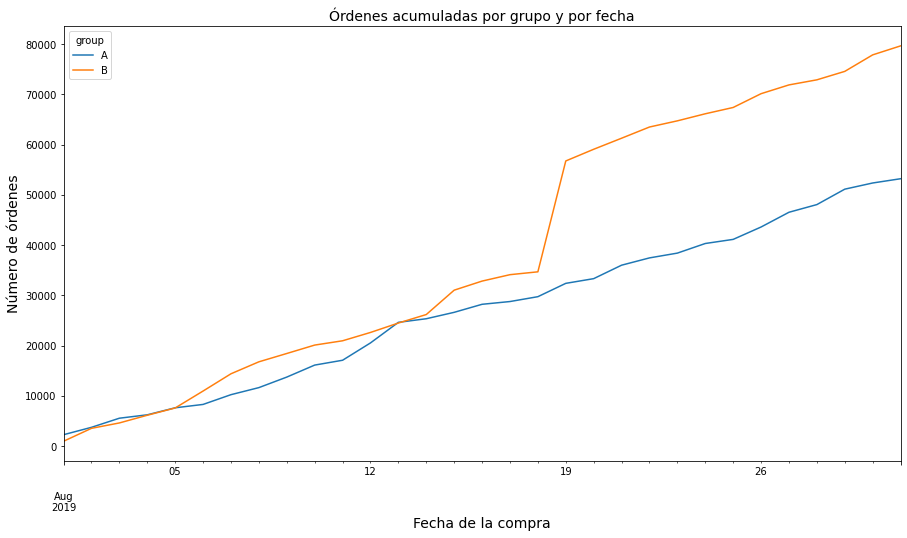

In [23]:
orders_filtred.pivot_table(index='date', values='revenue', columns='group', aggfunc='sum').cumsum().plot(figsize=(15, 8))
plt.xlabel('Fecha de la compra', fontsize=14)
plt.ylabel('Número de órdenes', fontsize=14)
plt.title('Órdenes acumuladas por grupo y por fecha', fontsize=14)
plt.xticks= (orders_filtred['date'])

En esta gráfica de datos acumulados por grupo, podemos observar que conforme avanza el mes de Agosto 2019, las ventas van subiendo para ambos grupos de forma consistente. El grupo B tuvo un mayor crecimiento en ingresos después de la primera mitad del mes (18 de Agosto) en donde se observa que tuvo un ingreso mayor hasta por 2000 unidades.

### **2. Tamaño de pedido promedio acumulado por grupo**


Text(0.5, 1.0, 'Tamaño de órdenes promedio acumulado por grupo y fecha')

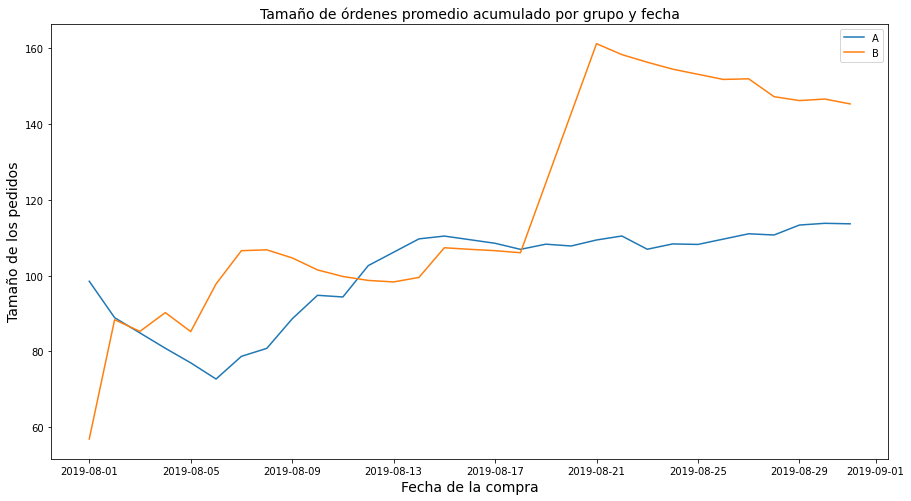

In [24]:
figure(figsize=(15,8))
plt.plot(cumulativeRevenueA['date'],cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label ='A')
plt.plot(cumulativeRevenueB['date'],cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.xlabel('Fecha de la compra', fontsize=14)
plt.ylabel('Tamaño de los pedidos', fontsize=14)
plt.title('Tamaño de órdenes promedio acumulado por grupo y fecha', fontsize=14)

Para el tamaño de las órdenes en ambos grupos, podemos ver que el mismo aumento conforme avanzó el mes. El grupo B nuevamente fue el que mayor crecimiento tuvo durante la prueba y tuvo órdenes más grandes que generaron mayores ingresos.

### **3. Diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B vs grupo A**

Text(0.5, 1.0, 'Diferencia relativa en tamaño de compra')

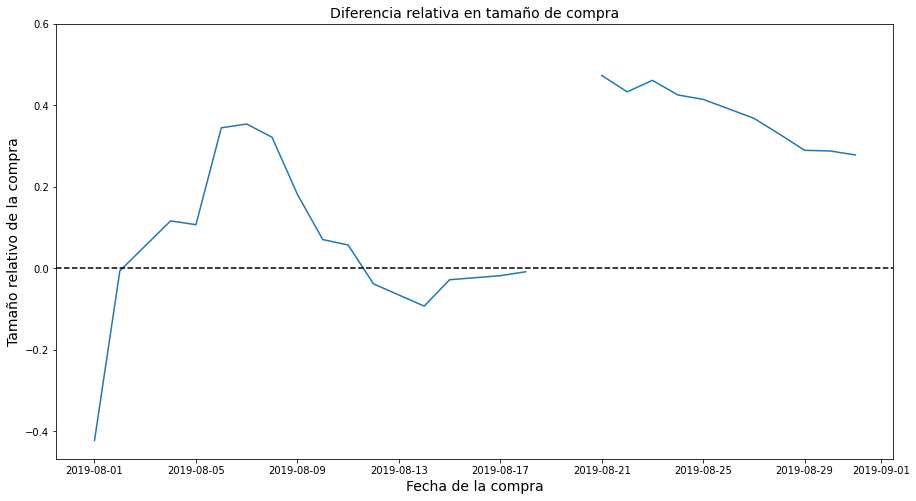

In [25]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

figure(figsize=(15,8))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Fecha de la compra', fontsize=14)
plt.ylabel('Tamaño relativo de la compra', fontsize=14)
plt.ylim(top=0.6)
plt.title('Diferencia relativa en tamaño de compra', fontsize=14)
#plt.legend()

En esta gráfica sobre la diferencia relativa podemos ver que hay saltos considerables en la gráfica, lo cual significa que hay ciertas órdenes que tienen tamaños muy grandes, mayores a lo esperado que podrían ser comrpas anormales.

### **4. Tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día. (tasas de conversión diarias de los dos grupos)**


Text(0.5, 1.0, 'VAriación de la tasa de conversión por grupos y por fecha')

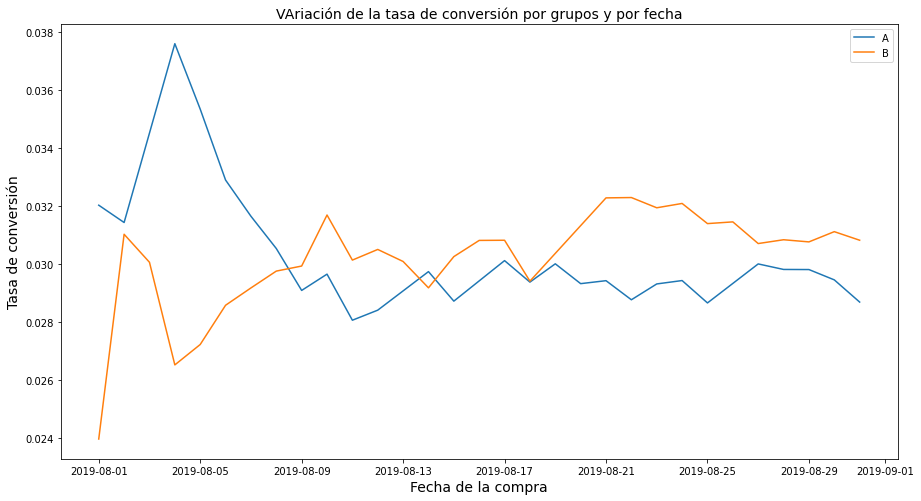

In [26]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visits']

# Selección de los datos por grupo
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

figure(figsize=(15,8))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xlabel('Fecha de la compra', fontsize=14)
plt.ylabel('Tasa de conversión', fontsize=14)
plt.title('VAriación de la tasa de conversión por grupos y por fecha', fontsize=14)

La tasa de conversión fluctuó bastante al principio de la prueba para ambos grupos, podemos ver que al final de la prueba, ambos grupos estabilizaron su tasa de conversión, y donde una vez más el grupo B es el que mayor conversión a comparación del grupo A.

In [27]:
# Número de visitas
datesGroups['n_visiters'] = ( 
    datesGroups.
    apply(lambda x: visits_filtred[np.logical_and(visits_filtred['date'] <= x['date'],
                                                  visits_filtred['group'] == x['group'])]
 ['visits'].sum(),
          axis = 1)
) 
datesGroups.head()

,date,group,n_visiters
0,2019-08-15,B,9550
7,2019-08-15,A,8389
45,2019-08-16,A,8389
47,2019-08-16,B,9961
55,2019-08-01,A,718


Text(0.5, 1.0, 'Variación del número de visitas por grupo')

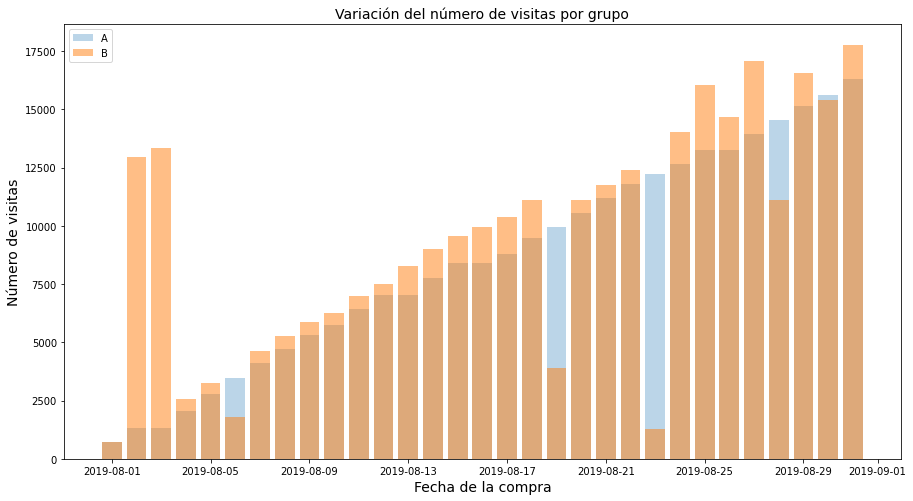

In [28]:
figure(figsize=(15,8))

x = datesGroups[datesGroups['group']=='A']['date']
plt.bar(x, datesGroups[datesGroups['group']=='A']['n_visiters'], label='A', alpha=0.3)
plt.bar(x, datesGroups[datesGroups['group']=='B']['n_visiters'], label='B', alpha= 0.5)
plt.legend()
plt.xlabel('Fecha de la compra', fontsize=14)
plt.ylabel('Número de visitas', fontsize=14)
plt.title('Variación del número de visitas por grupo', fontsize=14)
# Cómo le pongo los xticks para que sea la fecha en lugar de los números?

En esta gráfica podemos ver que ambos grupos tienen muchas visitas y que estas van aumentando conforme avanza la prubea.

Text(0.5, 1.0, 'Diferencia relativa para las tasas de conversión acumuladas')

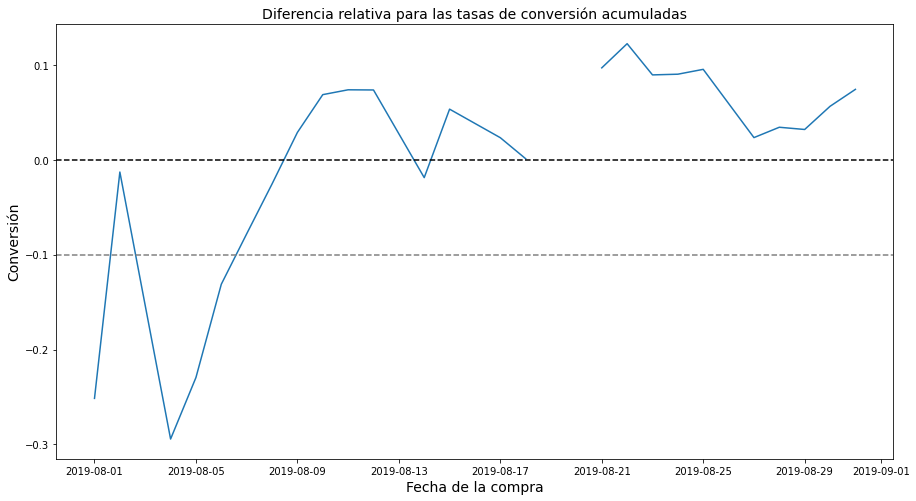

In [29]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

figure(figsize=(15,8))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.xlabel('Fecha de la compra', fontsize=14)
plt.ylabel('Conversión', fontsize=14)
plt.title('Diferencia relativa para las tasas de conversión acumuladas', fontsize=14)

### **5. Dispersión del número de pedidos por usuario**


In [30]:
number_orders_per_buyer = orders_filtred.groupby('visitorId').agg({'transactionId':'nunique'})
number_orders_per_buyer = ( 
    number_orders_per_buyer.rename(columns = {'transactionId':'count_orders'})
)
number_orders_per_buyer.head()

,count_orders
visitorId,
5114589,1
6958315,1
11685486,1
39475350,1
47206413,1


In [31]:
share_one_order = (
    len(number_orders_per_buyer[number_orders_per_buyer['count_orders'] == 1])
    /
    len(number_orders_per_buyer)
)
print('{:.2%} de los usuarios han realizado una sola orden'.format(share_one_order))

96.30% de los usuarios han realizado una sola orden


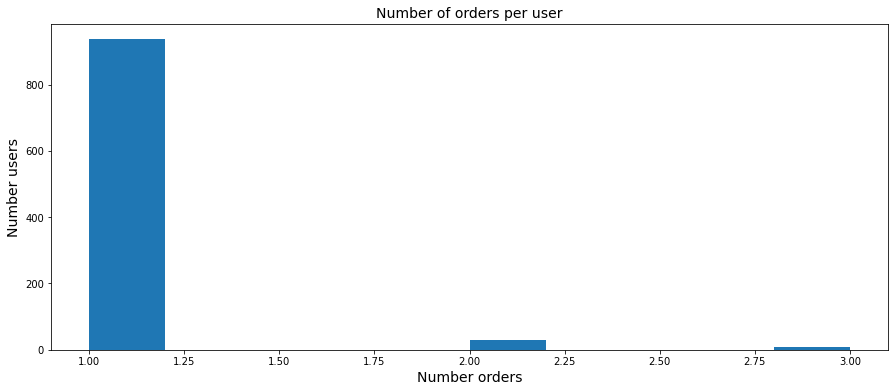

In [32]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.hist(number_orders_per_buyer['count_orders']) 
ax.set_xlabel('Number orders', fontsize=14)
ax.set_ylabel('Number users', fontsize=14)
ax.set_title('Number of orders per user', fontsize=14)

plt.show()

Text(0.5, 1.0, 'Número de órdenes por usuario')

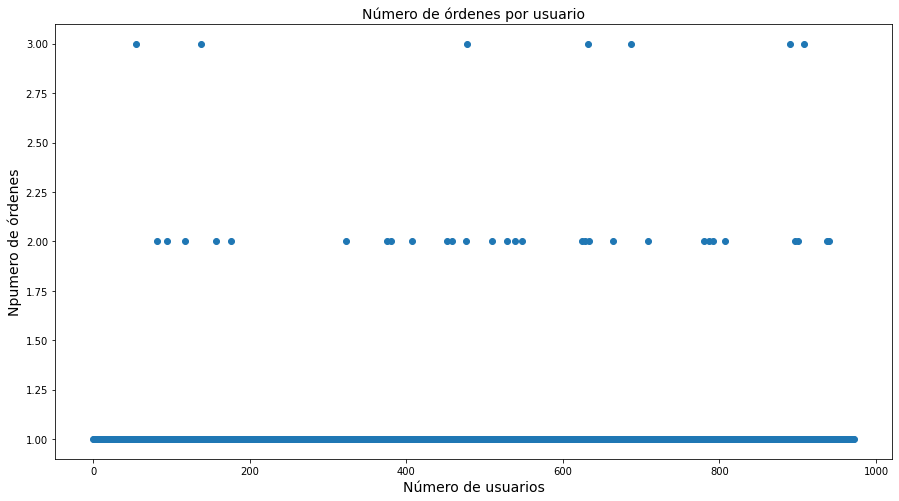

In [33]:
x_values = pd.Series(range(0, len(number_orders_per_buyer['count_orders'])))
figure(figsize=(15,8))
plt.scatter(x_values, number_orders_per_buyer['count_orders']) 
plt.xlabel('Número de usuarios', fontsize=14)
plt.ylabel('Npumero de órdenes', fontsize=14)
plt.title('Número de órdenes por usuario', fontsize=14)

En ambas gráficas podemos observar la distribución y dispersión de las órdenes relaizadas por los usaurios. La barra del histograma y la línea que se forma en el scatter muestran que la mayor proporción de los usuarios han realizado una sola compra, y hay un 3.7% restante que ha realizado más de una órden.

### **6. Percentiles 95 y 99 para el número de pedidos por usuario (punto en el cual un punto de datos se convierte en una anomalía)**


In [34]:
percentile_dict = [95, 99]
percentile = np.percentile(number_orders_per_buyer['count_orders'], percentile_dict)

print('{:}% de los usuarios realizaron más de {:.1f} órdenes'.format(100 - percentile_dict[0],percentile[0]))
print('{:}% de los usuarios realizaron más de {:.1f} órdenes'.format(100 - percentile_dict[1],percentile[1]))

5% de los usuarios realizaron más de 1.0 órdenes
1% de los usuarios realizaron más de 2.0 órdenes


Más de 2 órdenes se considera anormal, mientras que 1 y 2 son los límites de compras.

In [35]:
ordersByUsers = (
    orders_filtred.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsers.columns = ['visitorId', 'orders']
ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,visitorId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


### **7. Gráfico de dispersión de los precios de los pedidos** 


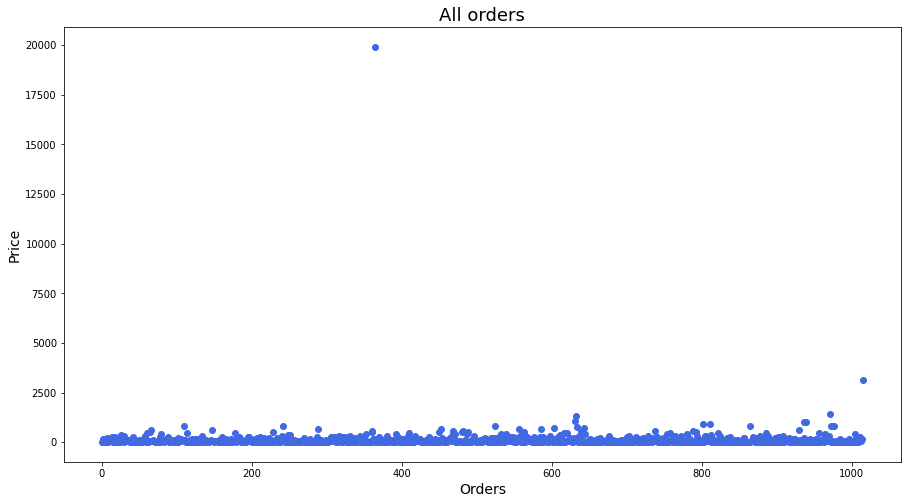

In [36]:
x_values = pd.Series(range(0,len(orders_filtred)))
figure(figsize=(15, 8))

plt.scatter(x_values, orders_filtred['revenue'], color = 'royalblue') 
plt.ylabel('Price', fontsize=14)       
plt.xlabel('Orders', fontsize=14)
plt.title('All orders', fontsize=18)
plt.show()

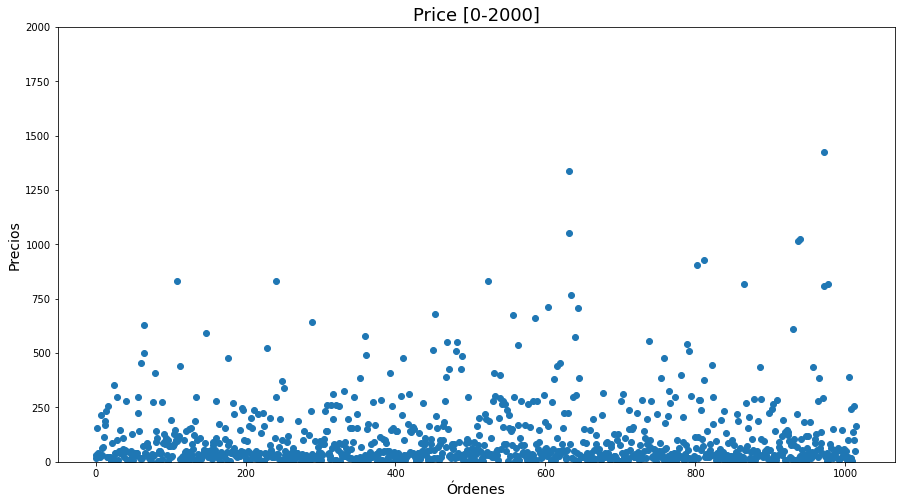

In [37]:
x_values = pd.Series(range(0,len(orders_filtred)))
figure(figsize=(15, 8))

plt.scatter(x_values, orders_filtred['revenue']) 
plt.ylabel('Precios', fontsize=14)  
plt.xlabel('Órdenes', fontsize=14)
plt.title('Price [0-2000]', fontsize=18)
plt.ylim([0, 2000])
plt.show()

### **8. Percentiles 95 y 99 de los precios de los pedidos (punto en el cual un punto de datos se convierte en una anomalía)**


In [38]:
percentile_dict = [95, 99]
percentile = np.percentile(orders_filtred['revenue'], percentile_dict)
print('{:}% de los usuarios realizaron órdenes de no más de {:.1f} dólares'.format(100 - percentile_dict[0],percentile[0]))
print('{:}% de los usuarios realizaron órdenes de no más de {:.1f} dólares'.format(100 - percentile_dict[1],percentile[1])) # Aquí calculando los del dataframe

5% de los usuarios realizaron órdenes de no más de 414.3 dólares
1% de los usuarios realizaron órdenes de no más de 830.3 dólares


Podríamos decir que mas de $500 es una anomalía en las órdenes que realizan los usuarios.

### **9. Significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto**


En esta sección vamos a realizar una prueba de Mann-Whitney, vamos a comparar los datos brutos del grupo A y el grupo B para determinar si hay diferencias de conversión. Utilizaremos el valor de alpha en 0.05.

* Hipótesis nula: No hay diferencia de conversión entre los grupos
* Hipótesis alternativa: Sí hay diferencia de conversión entre los grupos.

In [39]:
ordersByUsers_A = ( 
    orders_filtred[orders_filtred['group'] == 'A'].
    groupby('visitorId').
    agg({'transactionId':'nunique'})
)

ordersByUsers_A = ordersByUsers_A.rename(columns = {'transactionId':'orders'})
ordersByUsers_A.head()

,orders
visitorId,
11685486,1
54447517,1
66685450,1
78758296,1
85103373,1


In [40]:
ordersByUsers_B = ( 
    orders_filtred[orders_filtred['group'] == 'B'].
    groupby('visitorId').
    agg({'transactionId':'nunique'})
)
ordersByUsers_B = ordersByUsers_B.rename(columns = {'transactionId':'orders'})
ordersByUsers_B.head()

,orders
visitorId,
5114589,1
6958315,1
39475350,1
47206413,1
48147722,1


In [41]:
sampleA = (
    pd.concat([ordersByUsers_A['orders'],
               pd.Series(0, 
                         index = np.arange(visits_filtred[visits_filtred['group'] == 'A']
                                           ['visits']
                                           .sum() 
                                           -
                                           len(ordersByUsers_A['orders'])),
                         name = 'orders')],
              axis=0)
)
sampleA.head()

11685486    1
54447517    1
66685450    1
78758296    1
85103373    1
Name: orders, dtype: int64

In [42]:
sampleB = (
    pd.concat([ordersByUsers_B['orders'],
               pd.Series(0, 
                         index = np.arange(visits_filtred[visits_filtred['group'] == 'B']
                                           ['visits']
                                           .sum() 
                                           -
                                           len(ordersByUsers_B['orders'])),
                         name = 'orders')],
              axis=0)
)
sampleB.head()

5114589     1
6958315     1
39475350    1
47206413    1
48147722    1
Name: orders, dtype: int64

In [43]:
alpha = 0.05
results = st.mannwhitneyu(sampleA, sampleB)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Hipótesis nula rechazada: la diferencia es estadísticamente significativa")
else:
    print("No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia")

p-value:  0.18190470113728652
No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia


In [44]:
print("La diferencia de tamaño de pedido entre grupo B y grupo A es {0:.1f}% con los datos en bruto"
      .format((sampleB.mean()/sampleA.mean()-1)*100))

La diferencia de tamaño de pedido entre grupo B y grupo A es 7.4% con los datos en bruto


### **10. Significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto**


Mann-Whitney una vez más, vamos a comparar los datos brutos del grupo A y el grupo B para determinar si hay diferencias en los tamaños de pedido, igualmente utilizaremos el valor de alpha en 0.05.

* Hipótesis nula: No hay diferencia en los tamaños de pedido entre los grupos con los datos en bruto.
* Hipótesis alternativa: Sí hay diferencia en los tamaños de pedido entre los grupos con los datos en bruto.

In [45]:
revenue_A = orders_filtred[orders_filtred['group'] == 'A']['revenue']
revenue_B = orders_filtred[orders_filtred['group'] == 'B']['revenue']

alpha = 0.05
results = st.mannwhitneyu(revenue_A, revenue_B)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Hipótesis nula rechazada: la diferencia es estadísticamente significativa")
else:
    print("No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia")

p-value:  0.8622329690015668
No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia


In [46]:
print("La diferencia de conversión entre grupo B y grupo A es {0:.1f}% con los datos en bruto"
      .format((revenue_B.mean()/revenue_A.mean()-1)*100))

La diferencia de conversión entre grupo B y grupo A es 27.8% con los datos en bruto


### **11. Significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados**

A diferencia de la prueba anterior, vamos a realizar una prueba de Mann-Whitney también pero vamos a comparar los datos después de haberlos filtrado, tanto para el grupo A y B para determinar si hay diferencias de conversión. Utilizaremos el valor de alpha en 0.05 también.

* Hipótesis nula: No hay diferencia de conversión entre los grupos después de filtrar los datos.
* Hipótesis alternativa: Sí hay diferencia de conversión entre los grupos después de filtrar los datos.

In [47]:
ordersByUsers_A = ordersByUsers_A.reset_index()
ordersByUsers_B = ordersByUsers_B.reset_index()

usersWithManyOrders = pd.concat(
    [ordersByUsers_A[ordersByUsers_A['orders'] > 1]['visitorId'],
     ordersByUsers_B[ordersByUsers_B['orders'] > 1]['visitorId']],
     axis = 0)

usersWithExpensiveOrders = orders_filtred[orders_filtred['revenue'] > 414.3]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates()

In [48]:
sampleA_filtered = ( 
    pd.concat(
        [ordersByUsers_A[np.logical_not(ordersByUsers_A['visitorId'].
                                        isin(abnormalUsers))]['orders'],
         pd.Series(0, 
                   index = np.arange(visits_filtred[visits_filtred['group']=='A']
                                     ['visits'].sum() 
                                     - 
                                     len(ordersByUsers_A['orders'])),
                   name='orders')],
        axis=0)
)
sampleB_filtered = ( 
    pd.concat(
        [ordersByUsers_B[np.logical_not(ordersByUsers_B['visitorId'].
                                        isin(abnormalUsers))]['orders'],
         pd.Series(0, 
                   index = np.arange(visits_filtred[visits_filtred['group']=='B']
                                     ['visits'].sum() 
                                     - 
                                     len(ordersByUsers_B['orders'])),
                   name='orders')],
        axis=0)
)

In [49]:
alpha = 0.05
results = st.mannwhitneyu(sampleA_filtered, sampleB_filtered)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Hipótesis nula rechazada: la diferencia es estadísticamente significativa")
else:
    print("No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia")

p-value:  0.2087591984429097
No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia


In [50]:
print("La diferencia de conversión entre grupo B y grupo A es {0:.1f}% con los datos filtrados"
      .format((sampleB_filtered.mean()/sampleA_filtered.mean()-1)*100))

La diferencia de conversión entre grupo B y grupo A es 8.7% con los datos filtrados


### **12. Significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados**

En esta sección vamos a evaluar la diferencia en el tamaño promedio de los pedidos para ambos grupos.

* Hipótesis nula: No hay diferencia en los tamaños de pedido entre los grupos después de filtrar los datos.
* Hipótesis alternativa: Sí hay diferencia en los tamaños de pedido entre los grupos después de filtrar los datos.

In [51]:
revenue_A_filtered = (
    orders_filtred[(np.logical_not(orders_filtred['visitorId'].
                                   isin(abnormalUsers)))                
                   & (orders_filtred['group'] == 'A')])['revenue']
revenue_B_filtered = (
    orders_filtred[(np.logical_not(orders_filtred['visitorId'].
                                   isin(abnormalUsers)))                
                   & (orders_filtred['group'] == 'B')])['revenue']

In [52]:
alpha = 0.05
results = st.mannwhitneyu(revenue_A_filtered, revenue_B_filtered)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Hipótesis nula rechazada: la diferencia es estadísticamente significativa")
else:
    print("No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia")

p-value:  0.7711877309994826
No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia


In [53]:
print("La diferencia de tamaño de pedido entre grupo B y grupo A es {0:.1f}% con los datos filtrados"
      .format((revenue_B_filtered.mean()/revenue_A_filtered.mean()-1)*100))

La diferencia de tamaño de pedido entre grupo B y grupo A es -3.3% con los datos filtrados


### **13. Decisión basada en los resultados de la prueba**
Las decisiones posibles son:
1. Para la prueba, considera a uno de los grupos como líder.
2. Para la prueba, concluye que no hay diferencia entre los grupos.
3. Continúa la prueba.

Como hemos podido observar en las 4 pruebas distintas que realizamos de Mann-Whitney para determinar si hay alguna diferencia significativa entre los grupos tanto antes de filtrar (datos en bruto) como después de filtrarlos, tanto para la tasa de conversión y los tamaños de pedido, podemos concluir que:

1. No hay diferencia significativa en los grupos A y B en la tasa de conversión con los datos en bruto
2. No hay diferencia significativa en los grupos A y B en la tasa de conversión con los datos filtrados
3. No hay diferencia significativa en los grupos A y B en el tamaño de los pedidos con los datos en bruto
4. No hay diferencia significativa en los grupos A y B en el tamaño de los pedidos con los datos filtrados

Durante el análisis y el tratamiento de datos, lo principal que hicimos fue haber hecho la distinción de los usuarios que se encontraban tanto en el grupo A como en el grupo B, los eliminamos ya que podrían afectar los resultados finales de la prueba. Al haberlos removido lo que encontramos es que no hay diferencia en los grupos que sea estadísticamente significativa para los resultados que esperamos. La recomendación sería continuar con la prueba y tal vez realizar algunas modificaciones para poder obtener un resultado la próxima vez que sea significativo y poder implementar los cambios necesarios para aumentar tanto la tasa de conversión como el tamaño de los pedidos.